In [1]:
#Instalations
!pip install transformers
!pip install datasets
!pip install --upgrade pandas
!pip install evaluate
!pip install torch
!pip install "accelerate>=0.26.0"
!pip install transformers[torch]
!pip install seaborn
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 7.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 7.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 2.9 MB/s eta 0:00:00a 0:00:01


In [2]:
#Configs
data_path = "../../0. Dataset/cefr_leveled_texts200.csv"
text_column_name = "text"
label_column_name = "level"

model_name = "distilbert-base-uncased"
test_size = 0.25
num_labels = 6  # A1 A2 B1 B2 C1 C2

In [3]:
#Read and Prepare Dataset
import pandas as pd
df = pd.read_csv(data_path)

In [4]:
df

,Unnamed: 0,text,level,text_cleaned,label
0,0,"Let's go to see a movie, Anthony.\nThat sounds...",A1,"Let's go to see a movie, Anthony.\nThat sounds...",0
1,1,Every year we go to Florida. We like to go to ...,A1,Every year we go to Florida. We like to go to ...,0
2,2,Paula has cancer. She has six months to live. ...,A1,Paula has cancer. She has six months to live. ...,0
3,3,There's a huge rip here.\nBut there's tape on ...,A1,There's a huge rip here.\nBut there's tape on ...,0
4,4,Patty got a doll for Christmas. It is her favo...,A1,Patty got a doll for Christmas. It is her favo...,0
...,...,...,...,...,...
1195,1195,Anarchist rejection of authority has applicati...,C2,Anarchist rejection of authority has applicati...,5
1196,1196,﻿Nobody knows which came first: the economic c...,C2,Nobody knows which came first: the economic cr...,5
1197,1197,﻿Police and intelligence agencies around the w...,C2,Police and intelligence agencies around the wo...,5
1198,1198,The deadly attack in Kabul on Shi'ite worshipp...,C2,The deadly attack in Kabul on Shi'ite worshipp...,5


In [5]:
#Train/Test Split
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,test_size=test_size)

In [6]:
#Convert to Huggingface Dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [7]:
#Tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text_cleaned"], truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [9]:
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [10]:
#Initialize Model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
#Train model
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [14]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=12,
    weight_decay=0.01,
    eval_strategy = "epoch",
    logging_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics

)

In [15]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,1.266400,1.076282,0.466667
2,0.926200,0.902097,0.600000
3,0.532500,1.166406,0.543333
4,0.347000,1.017774,0.650000
5,0.202900,1.172764,0.680000
6,0.126900,1.482102,0.646667
7,0.051100,1.547896,0.680000
8,0.037900,1.673216,0.656667
9,0.013100,1.827254,0.673333
10,0.005100,2.033955,0.643333


TrainOutput(global_step=348, training_loss=0.2928388734701379, metrics={'train_runtime': 626.3836, 'train_samples_per_second': 17.242, 'train_steps_per_second': 0.556, 'total_flos': 1430749959782400.0, 'train_loss': 0.2928388734701379, 'epoch': 12.0})

In [16]:
# Evaluate Model (con ejemplos del entrenamiento)
from sklearn.metrics import classification_report
preds = trainer.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00       141
           3       1.00      1.00      1.00       146
           4       1.00      1.00      1.00       163
           5       1.00      1.00      1.00       158

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [17]:
# Evaluate Model (con nuevos ejemplos)
preds = trainer.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        60
           1       0.67      0.77      0.72        48
           2       0.61      0.46      0.52        59
           3       0.51      0.54      0.52        54
           4       0.46      0.68      0.55        37
           5       0.82      0.67      0.74        42

    accuracy                           0.65       300
   macro avg       0.66      0.65      0.65       300
weighted avg       0.66      0.65      0.65       300



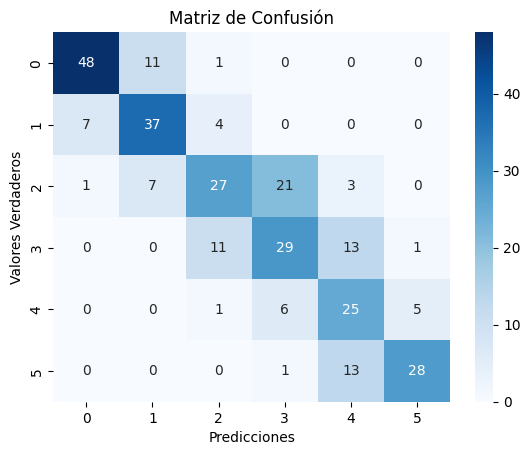

In [18]:
# Matriz de confusión del Test.
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(df_test['label'], preds)

# Visualizar la matriz de confusión con un heatmap
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')

# Añadir títulos y etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

In [19]:
# Guardar Modelo?
trainer.save_model('Clasificador_en_200_Bert')
# Usar Modelo?
#model = BertModel.from_pretrained("/content/Clasificador_200_Bert")

In [20]:

tokenizer.save_pretrained('Clasificador_en_200_Bert')


('Clasificador_en_200_Bert/tokenizer_config.json',
 'Clasificador_en_200_Bert/special_tokens_map.json',
 'Clasificador_en_200_Bert/vocab.txt',
 'Clasificador_en_200_Bert/added_tokens.json',
 'Clasificador_en_200_Bert/tokenizer.json')

In [21]:

from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Cargar el modelo y el tokenizer desde la carpeta
model = AutoModelForSequenceClassification.from_pretrained("/content/Clasificador_en_200_Bert")
tokenizer = AutoTokenizer.from_pretrained("/content/Clasificador_en_200_Bert")


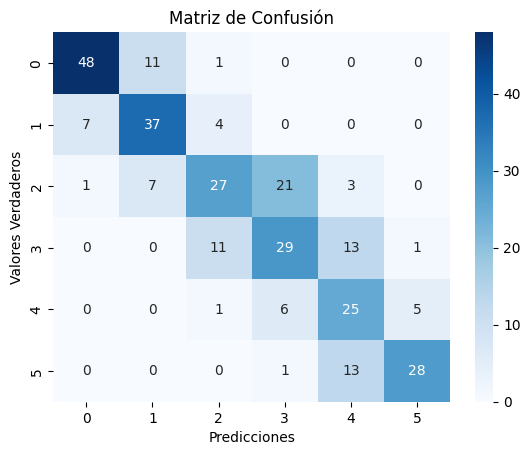

In [22]:

import matplotlib.pyplot as plt
import numpy as np

# Función para predecir la etiqueta de un texto
def predict_label(text):
  inputs = tokenizer(text, return_tensors="pt", truncation=True)
  outputs = model(**inputs)
  logits = outputs.logits
  predicted_label = np.argmax(logits.detach().numpy(), axis=1)[0]
  return predicted_label


# Crear una lista para almacenar las predicciones
predictions = []

# Iterar sobre el conjunto de prueba y hacer predicciones
for index, row in df_test.iterrows():
  text = row["text"]
  true_label = row["label"]
  predicted_label = predict_label(text)
  predictions.append(predicted_label)

# Calcular la matriz de confusión
matrix = confusion_matrix(df_test["label"], predictions)

# Visualizar la matriz de confusión con un heatmap
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')

# Añadir títulos y etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()
